# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scrapbook as sb

In [70]:
import  matplotlib.pyplot as plt
%matplotlib inline
fig_height = 10
fig_width =15
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

Please insert you  firstname  and name below

In [3]:
sb.glue("Who", ["FirstName", "Name"])

In [4]:
from  sklearn.model_selection import train_test_split
seed = 31287

In [5]:
data = pd.read_csv('data/banknotes_data.csv')

In [6]:
data.head()

,a0,a1,a2,a3,counterfeit
0,-1.1306,1.8458,-1.35750,-1.38060,1
1,-1.1188,3.3357,-1.34550,-1.95730,1
2,2.6719,3.0646,0.37158,0.58619,0
3,-4.1409,3.4619,-0.47841,-3.88790,1
4,1.4507,8.7903,-2.23240,-0.65259,0


In [7]:
data.describe()

,a0,a1,a2,a3,counterfeit
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,0.431116,1.902054,1.426607,-1.220393,0.444254
std,2.845672,5.942260,4.397341,2.101777,0.497096
min,-7.042100,-13.773100,-5.286100,-7.871900,0.000000
25%,-1.770900,-1.916200,-1.664300,-2.466150,0.000000
50%,0.471345,2.408650,0.567365,-0.614450,0.000000
75%,2.816925,6.800675,3.338825,0.394810,1.000000
max,6.824800,12.730200,17.927400,2.449500,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a0           1166 non-null   float64
 1   a1           1166 non-null   float64
 2   a2           1166 non-null   float64
 3   a3           1166 non-null   float64
 4   counterfeit  1166 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 45.7 KB


In [9]:
data_train, data_test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data.loc[:,'counterfeit'], random_state=seed)

In [10]:
lbls_train = data_train['counterfeit']

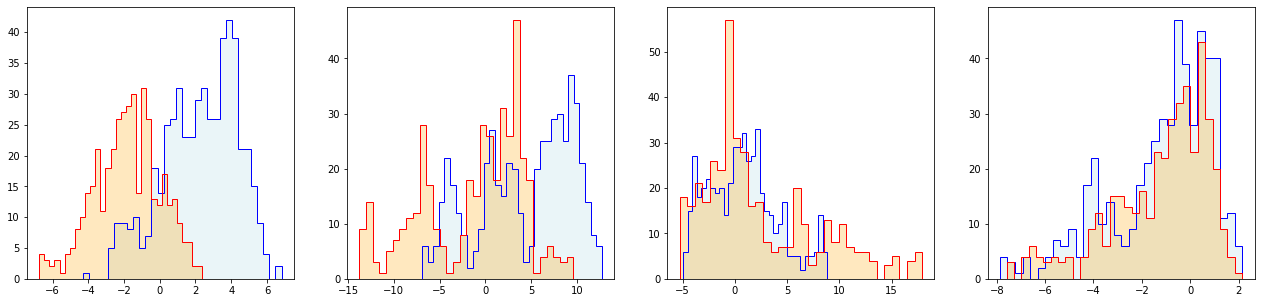

In [11]:
fig, ax = plt.subplots(1,4, figsize=(22,5))
for i in range(4):
    ax[i].hist(data_train[lbls_train==0].iloc[:,i], bins=32, histtype='step', color='blue')
    ax[i].hist(data_train[lbls_train==1].iloc[:,i], bins=32, histtype='step', color='red')
    ax[i].hist(data_train[lbls_train==0].iloc[:,i], bins=32, histtype='bar', color='lightblue', alpha=0.25)
    ax[i].hist(data_train[lbls_train==1].iloc[:,i], bins=32, histtype='bar', color='orange', alpha =0.25)

You will have to install a popular plotting library `seaborn`

In [12]:
import seaborn

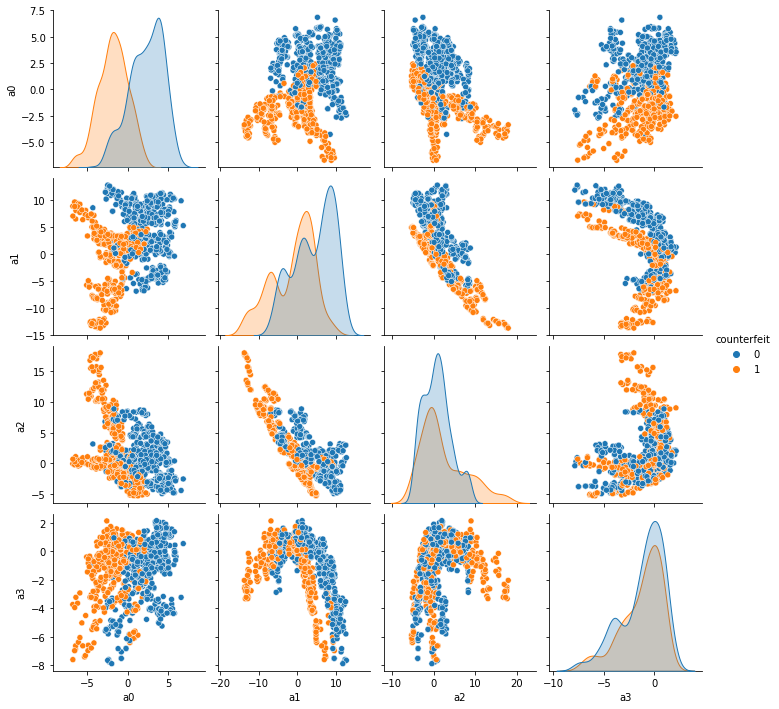

In [13]:
seaborn.pairplot(data_train.iloc[:,0:5], hue='counterfeit');

In [14]:
len(data_train)

932

## Problem 1

Implement Gaussian  Bayes classifier using only one feature. Which feature will you choose? Calculate the confusion matrix (normalized as to show rates), ROC AUC score and plot ROC curve. Do this bot for training and validation set. Plot both curves on the same plot. Save everything using `scrapbook`. 

__Hint__ For calculating metrics and plotting ROC curves you may use functions from scikit-learn: `roc_curve`, `roc_auc_score` and `confusion matrix`. For estimating normal distribution parameters  use `norm.fit` `from scipy.stats`. Use `norm.pdf` for normal probability density function.

In [59]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [55]:
def make_pdf_P_cond(labels, data):
    """Takes labels (0,1) and a single feature and returns the conditional 
    probability distribution function of the   positive label given the feature assuming
    normal distribution of the  feature values.
    """
    
    positives = data[labels==1]
    negatives = data[labels==0]
    
    pd_cond_P = st.norm(*st.norm.fit(positives))
    pd_cond_N = st.norm(*st.norm.fit(negatives))
    
    pdf_cond_P = pd_cond_P.pdf
    pdf_cond_N = pd_cond_N.pdf
    
    P_P = labels.mean()
    P_N = 1-P_P
    
    def pdf(x):
        return pdf_cond_P(x)*P_P/(pdf_cond_P(x)*P_P+pdf_cond_N(x)*P_N)

    return pdf

In [56]:
pdf_a_cond = make_pdf_P_cond(data_train.counterfeit==1, data_train.a0)

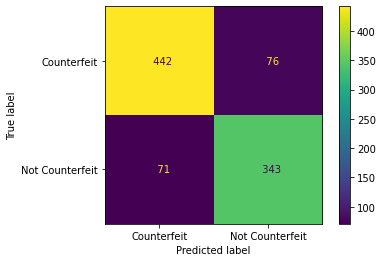

In [65]:
train_labels = data_train.counterfeit==1
train_classification = pdf_a_cond(data_train.a0)>0.5
ConfusionMatrixDisplay.from_predictions(train_labels, train_classification, display_labels=('Counterfeit', 'Not Counterfeit'), values_format='5d');

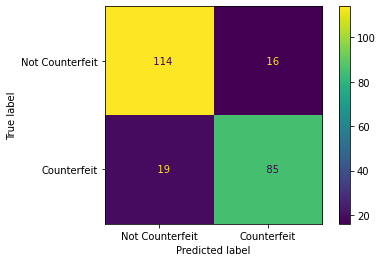

In [66]:
test_labels = data_test.counterfeit==1
test_classification = pdf_a_cond(data_test.a0)>0.5
ConfusionMatrixDisplay.from_predictions(test_labels, test_classification, display_labels=('Not Counterfeit', 'Counterfeit'), values_format='5d');

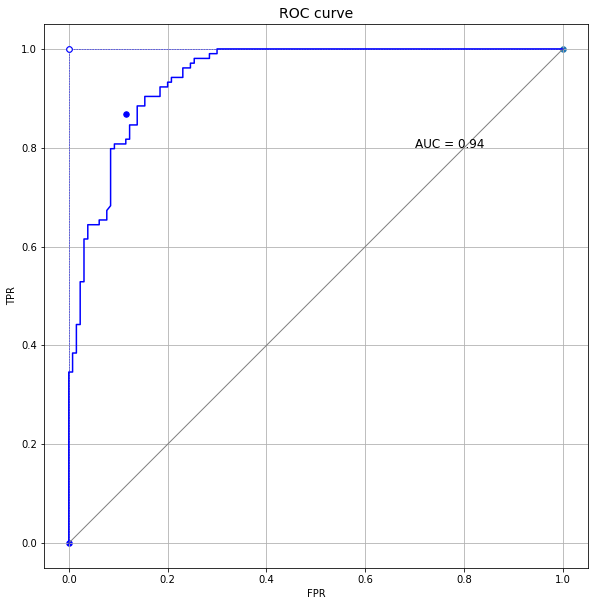

In [85]:
fprs, tprs, thds = roc_curve(test_labels, pdf_a_cond(data_test.a0))
a_auc = roc_auc_score(test_labels, pdf_a_cond(data_test.a0))
def roc_plot(figsize=[fig_height,fig_height]):
    """Returns figure and axes object for plotting ROC curve
    setting aspect ration to one and labeling the axes.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect(1)
    ax.set_xlabel('FPR');
    ax.set_ylabel('TPR');
    return fig,ax
fig, ax = roc_plot()
fpr = np.sum(test_classification> test_labels)/np.sum(test_labels)
fnr = np.sum(test_classification < test_labels)/(len(test_labels)-np.sum(test_labels))
tpr = 1-fnr

roc = ax.plot(fprs,tprs, color='blue');
ax.scatter([fpr],[tpr],s = 30, color='blue', zorder=5)
ax.text(0.7, 0.8, "AUC = {:4.2f}".format(a_auc), fontsize=12);

ax.set_title("ROC curve", fontsize=14);
ax.plot([0,1],[0,1],'-', c='grey', linewidth = 1 )
ax.plot([0,0,1],[0,1,1],'--', c = roc[0].get_color() , linewidth=0.5)
ax.scatter([0],[0],s = 30, c = roc[0].get_color() )
ax.scatter([1],[1],s = 30)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.grid()

## Problem 2

Same as Problem 1 but now implement Gaussian Naive Bayes using two features. Compare ROC curves on the test set. What is teh improvement of AUC score on the test set?

In [75]:
def make_pdf_P_cond2(labels, data1, data2):
    """Takes labels (0,1) and a single feature and returns the conditional 
    probability distribution function of the   positive label given the feature assuming
    normal distribution of the  feature values.
    """
    
    positives1 = data1[labels==1]
    negatives1 = data1[labels==0]
    
    positives2 = data2[labels==1]
    negatives2 = data2[labels==0]
    
    pdf_cond_P1 = st.norm(*st.norm.fit(positives1)).pdf
    pdf_cond_N1 = st.norm(*st.norm.fit(negatives1)).pdf
    
    pdf_cond_P2 = st.norm(*st.norm.fit(positives2)).pdf
    pdf_cond_N2 = st.norm(*st.norm.fit(negatives2)).pdf
    
    P_P = labels.mean()
    P_N = 1-P_P
    
    def pdf(x1, x2):
        p_prod = pdf_cond_P1(x1)*pdf_cond_P2(x2)*P_P
        n_prod = pdf_cond_N1(x1)*pdf_cond_N2(x2)*P_N
        return p_prod/(p_prod + n_prod)

    return pdf

In [80]:
pdf_a_cond2 = make_pdf_P_cond2(data_train.counterfeit==1, data_train.a0, data_train.a1)

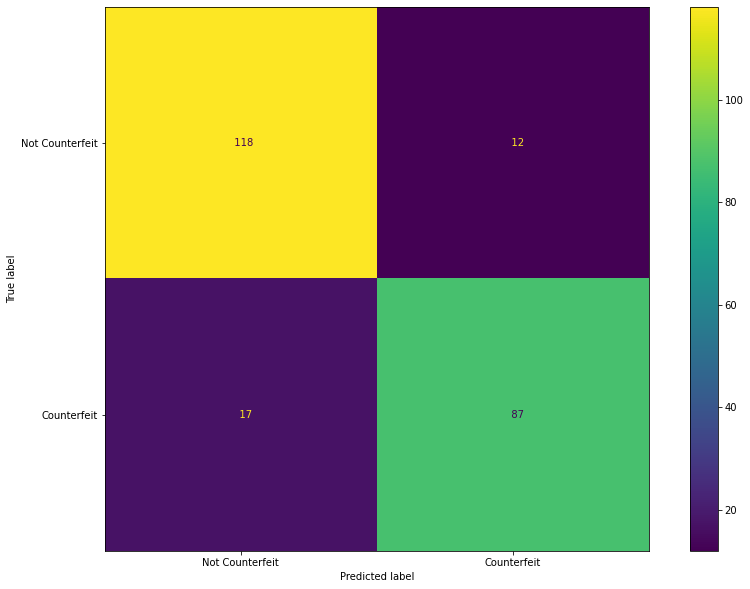

In [81]:
test_labels = data_test.counterfeit==1
test_classification = pdf_a_cond2(data_test.a0, data_test.a1)>0.5
ConfusionMatrixDisplay.from_predictions(test_labels, test_classification, display_labels=('Not Counterfeit', 'Counterfeit'), values_format='5d');

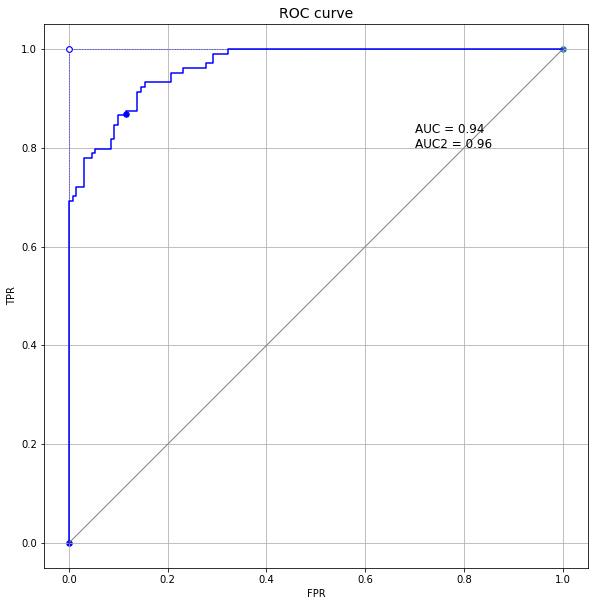

In [87]:
fprs, tprs, thds = roc_curve(test_labels, pdf_a_cond2(data_test.a0, data_test.a1))
a_auc2 = roc_auc_score(test_labels, pdf_a_cond2(data_test.a0, data_test.a1))
def roc_plot(figsize=[fig_height,fig_height]):
    """Returns figure and axes object for plotting ROC curve
    setting aspect ration to one and labeling the axes.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect(1)
    ax.set_xlabel('FPR');
    ax.set_ylabel('TPR');
    return fig,ax
fig, ax = roc_plot()
fpr = np.sum(test_classification> test_labels)/np.sum(test_labels)
fnr = np.sum(test_classification < test_labels)/(len(test_labels)-np.sum(test_labels))
tpr = 1-fnr

roc = ax.plot(fprs,tprs, color='blue');
ax.scatter([fpr],[tpr],s = 30, color='blue', zorder=5)
ax.text(0.7, 0.8, "AUC = {:4.2f}\nAUC2 = {:4.2f}".format(a_auc, a_auc2), fontsize=12);

ax.set_title("ROC curve", fontsize=14);
ax.plot([0,1],[0,1],'-', c='grey', linewidth = 1 )
ax.plot([0,0,1],[0,1,1],'--', c = roc[0].get_color() , linewidth=0.5)
ax.scatter([0],[0],s = 30, c = roc[0].get_color() )
ax.scatter([1],[1],s = 30)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.grid()

## Problem 3

Same as Problem 2 but now implement Gaussian Naive Bayes using all features.

In [111]:
def make_pdf_P_condall(labels, data):
    """Takes labels (0,1) and a single feature and returns the conditional 
    probability distribution function of the   positive label given the feature assuming
    normal distribution of the  feature values.
    """
    positives = []
    negatives = []
    for d in data:
        positives.append(d[labels==1])
        negatives.append(d[labels==0])
    
    pdf_cond_Ps = []
    pdf_cond_Ns = []
    for p in positives:
        pdf_cond_Ps.append(st.norm(*st.norm.fit(p)).pdf)
        
    for n in negatives:
        pdf_cond_Ns.append(st.norm(*st.norm.fit(n)).pdf)
    
    P_P = labels.mean()
    P_N = 1-P_P
    
    def pdf(x):
        p_prod = P_P
        n_prod = P_N
        for i, pp in enumerate(pdf_cond_Ps):
            p_prod *= pp(x[i])
        for i, pn in enumerate(pdf_cond_Ns):
            n_prod *= pn(x[i])
        return p_prod/(p_prod + n_prod)

    return pdf

In [112]:
pdf_a_condall = make_pdf_P_condall(data_train.counterfeit==1, [data_train[d] for d in data_train.iloc[:,0:4]])

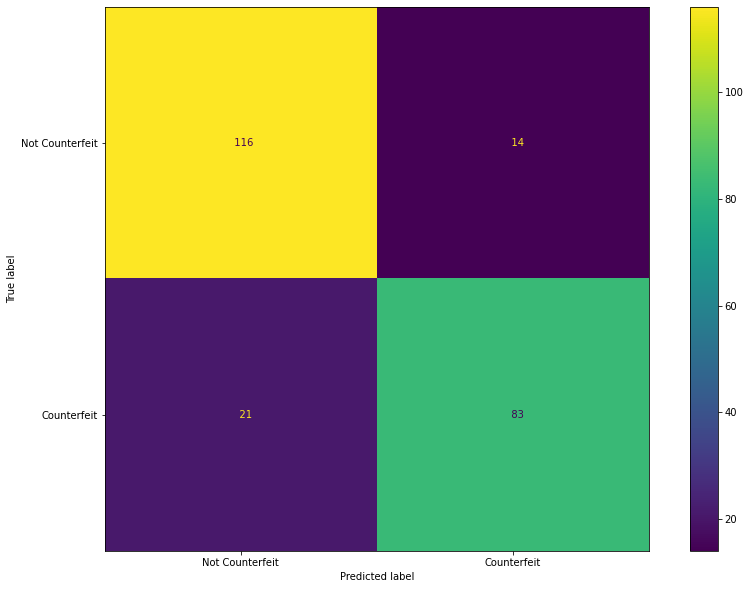

In [113]:
test_labels = data_test.counterfeit==1
test_classification = pdf_a_condall([data_test[d] for d in data_test.iloc[:,0:4]])>0.5
ConfusionMatrixDisplay.from_predictions(test_labels, test_classification, display_labels=('Not Counterfeit', 'Counterfeit'), values_format='5d');

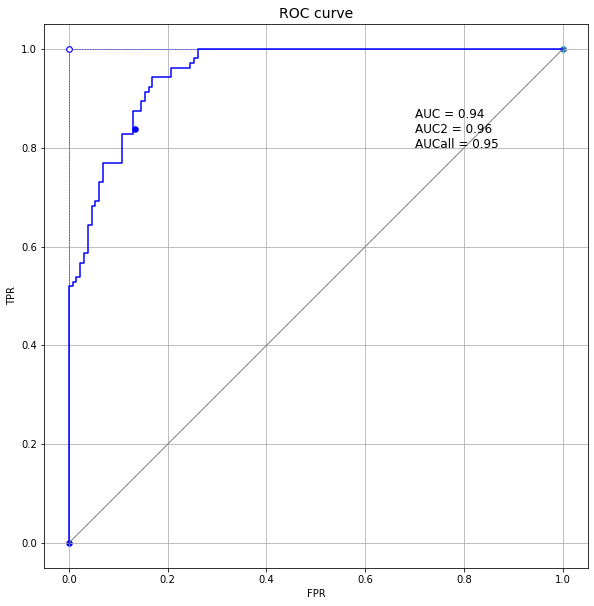

In [114]:
fprs, tprs, thds = roc_curve(test_labels, pdf_a_condall([data_test[d] for d in data_test.iloc[:,0:4]]))
a_aucall = roc_auc_score(test_labels, pdf_a_condall([data_test[d] for d in data_test.iloc[:,0:4]]))
def roc_plot(figsize=[fig_height,fig_height]):
    """Returns figure and axes object for plotting ROC curve
    setting aspect ration to one and labeling the axes.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_aspect(1)
    ax.set_xlabel('FPR');
    ax.set_ylabel('TPR');
    return fig,ax
fig, ax = roc_plot()
fpr = np.sum(test_classification> test_labels)/np.sum(test_labels)
fnr = np.sum(test_classification < test_labels)/(len(test_labels)-np.sum(test_labels))
tpr = 1-fnr

roc = ax.plot(fprs,tprs, color='blue');
ax.scatter([fpr],[tpr],s = 30, color='blue', zorder=5)
ax.text(0.7, 0.8, "AUC = {:4.2f}\nAUC2 = {:4.2f}\nAUCall = {:4.2f}".format(a_auc, a_auc2, a_aucall), fontsize=12);

ax.set_title("ROC curve", fontsize=14);
ax.plot([0,1],[0,1],'-', c='grey', linewidth = 1 )
ax.plot([0,0,1],[0,1,1],'--', c = roc[0].get_color() , linewidth=0.5)
ax.scatter([0],[0],s = 30, c = roc[0].get_color() )
ax.scatter([1],[1],s = 30)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.scatter([0],[1],s = 30, edgecolor='blue', facecolor='white', zorder=5)
ax.grid()